## QML for Breast Cancer Classification
##### -By Pradiksha Devi

#### 1. Importing basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#### 2. Loading Wisconsin Breast Cancer Dataset

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

#### 3. Converting the sklearn dataset to the pandas dataframe

In [3]:
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df['target'] = data.target

#### 4. Assigning Dependent and Independent variables

In [4]:
d = df
X = d.drop(['target'], axis=1)
y = d['target']

#### 5. Standardizing features

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

#### 6. Dimensionality reduction with PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.44272026 0.18971182 0.09393163 0.06602135]


#### 7. Normalizing the data which is needed for VQC algorithm

In [7]:
from sklearn.preprocessing import MinMaxScaler
X_normalized = MinMaxScaler().fit_transform(X_pca)

#### 8. Splitting the dataset into training and testing

In [8]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_feature, test_feature, train_labels, test_labels = train_test_split(
    X_normalized, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

#### 9. Encoding the data as qubits by creating the quantum circuit with 4 qubits

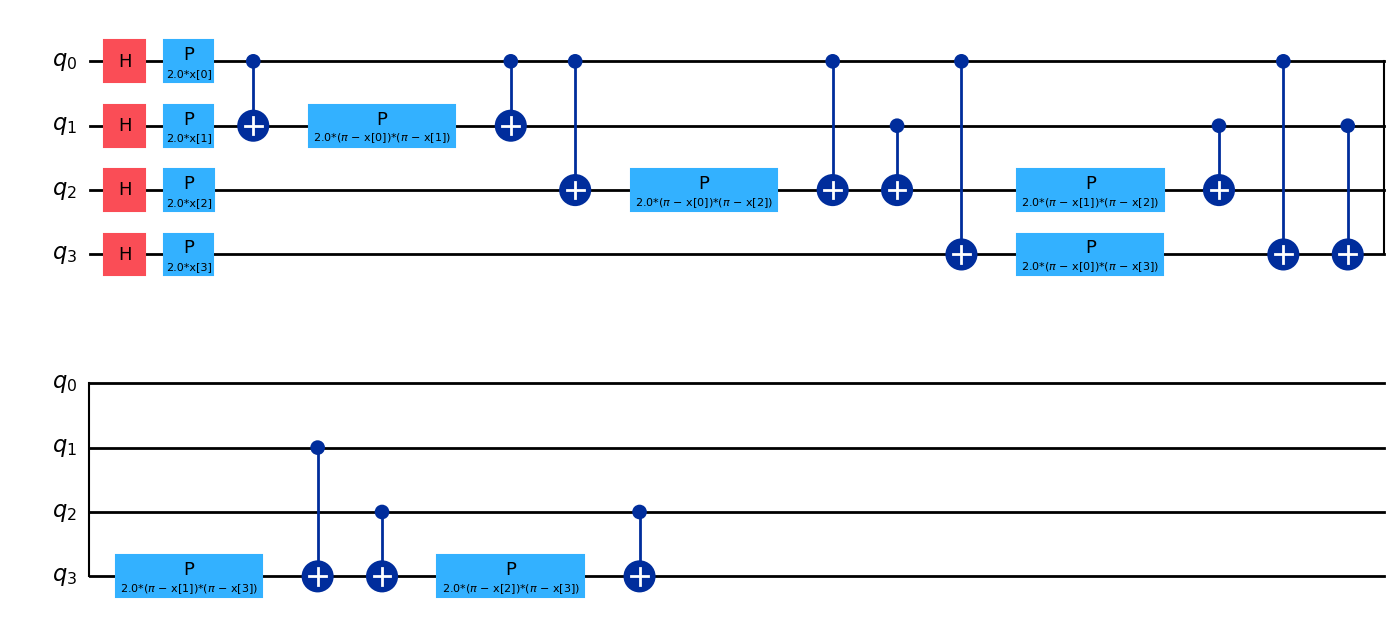

In [9]:
from qiskit.circuit.library import ZZFeatureMap

num_features = train_feature.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output='mpl', fold=20, filename='featuremap')

#### 10. Parameterized circuit

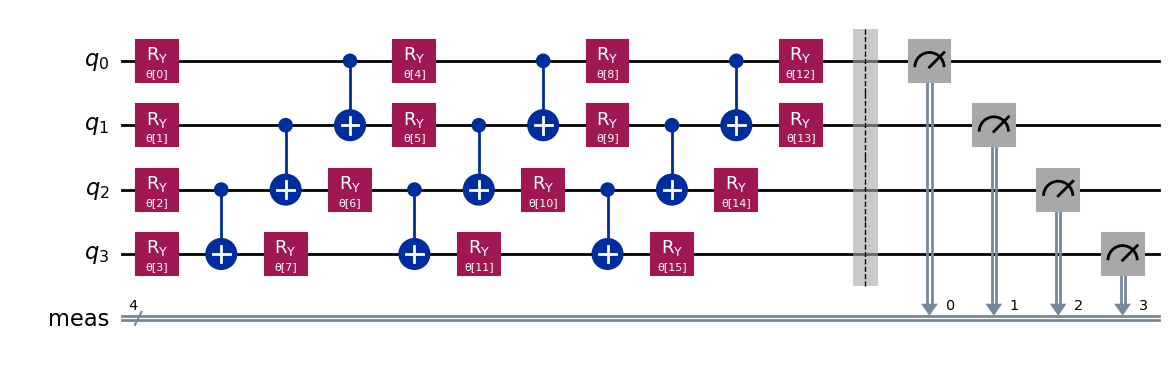

In [10]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.measure_all() 
ansatz.decompose().draw(output='mpl', fold=20, filename='ansatz')

#### 11. Combining the feature map with the circuit

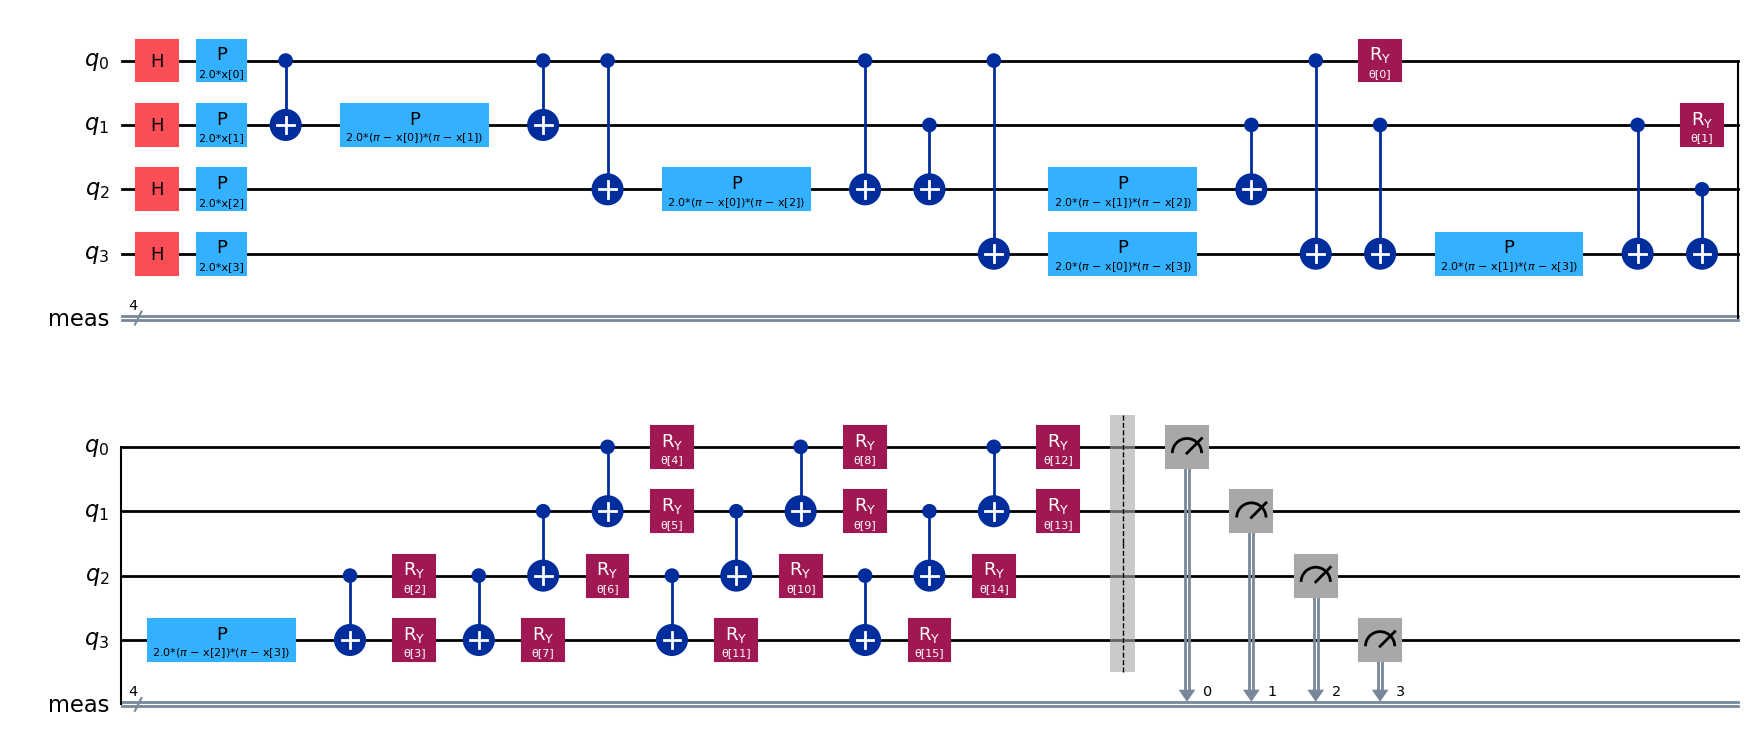

In [11]:
circuit = feature_map.compose(ansatz)
circuit.decompose().draw(output='mpl', filename='overallcircuit.png')

#### 12. Setting up initial random values for the gates ("weights")

In [12]:
initial_point = np.random.random(ansatz.num_parameters)
initial_point

array([7.55962390e-01, 4.06058450e-04, 9.08809475e-01, 8.22426171e-01,
       4.13869071e-02, 5.34402808e-01, 3.43519453e-01, 7.99828848e-01,
       2.59056088e-01, 9.74371693e-01, 2.10953168e-02, 3.06747476e-01,
       7.92487971e-01, 1.46114528e-01, 9.34548229e-01, 3.59014297e-01])

#### 13. One hot encoding as required by the VQC algorithm

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

train_labels_oh = encoder.fit_transform(train_labels.reshape(-1,1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1,1)).toarray()

#### 14. Importing necessary qiskit Libraries and modules

In [ ]:
from qiskit_aer.primitives import Sampler
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.algorithms.classifiers import VQC

#### 15. Defining Variational Quantum Classifier object

In [58]:
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss='cross_entropy',
    optimizer=SPSA(),
    initial_point=initial_point,
    sampler=Sampler()
)

#### 16. Training and testing accuracy

In [52]:
vqc.fit(train_feature, train_labels_oh)

In [53]:
print(f'Quantum VQC test accuracy: {vqc.score(test_feature, test_labels_oh):.2f}')

Quantum VQC test accuracy: 0.85


#### Quantum Computer

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.98204467 0.01617649]


In [67]:
from sklearn.preprocessing import MinMaxScaler
X_scaled_qc = MinMaxScaler().fit_transform(X)

In [69]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(X_scaled_qc, y, train_size=0.8, random_state=algorithm_globals.random_seed)

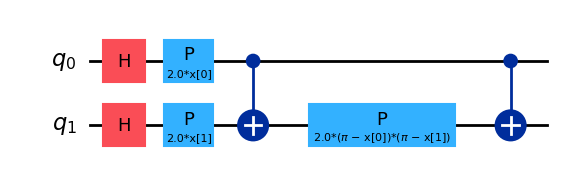

In [71]:
from qiskit.circuit.library import ZZFeatureMap

num_features = train_features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output='mpl', fold=20, filename='featuremap')

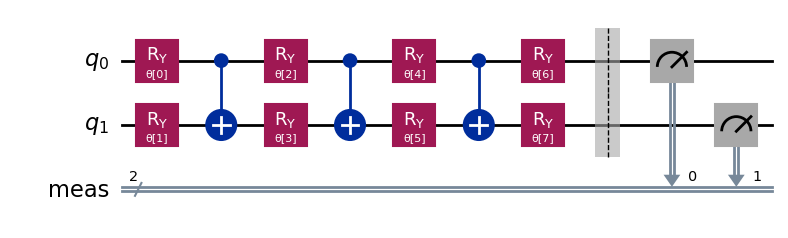

In [72]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.measure_all() 
ansatz.decompose().draw(output='mpl', fold=20, filename='ansatz')

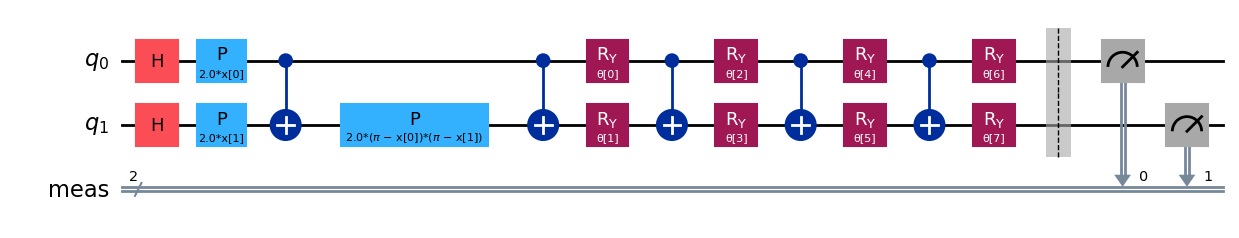

In [73]:
circuit = feature_map.compose(ansatz)
circuit.decompose().draw(output='mpl', filename='overallcircuit.png')

In [74]:
initial_point = np.random.random(ansatz.num_parameters)
initial_point

array([0.15268424, 0.84777475, 0.06688995, 0.68534015, 0.21271103,
       0.9128532 , 0.83004029, 0.0765739 ])

In [80]:
from qiskit_ibm_provider import IBMProvider
from qiskit.primitives import BackendSampler

IBMProvider.save_account(token="dff7fce0a664edffa936f626b435fc357a0e778cda8c3e9c0c0230fee4f4d39bdb8aa7c4659834aedb5e785e5b2d736e180dfd4d387c73a0b8c3259cc3a2d669", overwrite=True)

In [85]:
for backend in provider.backends():
    print(backend.name)

ibm_brisbane
ibm_sherbrooke


In [93]:
provider = IBMProvider()

q_computer = provider.get_backend('ibm_sherbrooke')

# Set options to disable dynamic circuits
sampler = BackendSampler(
    backend=q_computer,
    options={"transpilation": {"translation_method": "synthesis",
                               "layout_method": "trivial"}}
)

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss='cross_entropy',
    optimizer=SPSA(),
    initial_point=initial_point,
    sampler=sampler
)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3204\4232113538.py:6: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler = BackendSampler(


In [ ]:
vqc.fit(train_features, train_labels_oh)

In [ ]:
print(f'Quantum VQC test accuracy')